# Bermudan Options in TensorFlow

This code was written to demonstrate how to implement the Longstaff-Schwartz method in TensorFlow


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Helper function

In [12]:
def get_continuation_function():
    """
    Create the graph to solve the longstaff schwartz regression 
    to calculate the continuation value given a state via a
    stochastic gradient optimization
    """
    X = tf.placeholder(tf.float32, (None, 3))
    y = tf.placeholder(tf.float32, (None, 1))
    w = tf.Variable(initial_value=tf.random_normal((3,1))*0.1)
    b = tf.Variable(initial_value=tf.ones(1)*1)
    y_hat = tf.add(tf.matmul(X,w), b)
    pre_error = tf.pow(y-y_hat,2)
    error = tf.reduce_mean(pre_error)
    train = tf.train.AdamOptimizer(0.1).minimize(error)
    return(X, y, train, w, b, y_hat)

def feature_matrix_from_current_state(state):
    """
    calculate the first 4 chebyshev polynominals of the current state
    and returns a  (n x 4) feature maxtix with n numbers of simulated paths
    
    input: state : n-dim vector with the state of the process at exercise time t
    
    output: feature matrix for the longstaff schwartz regression
    """
    feature_0 = tf.pow(state,0)

    feature_1 = tf.pow(state,1)
    feature_1_mean = tf.reduce_mean(feature_1)
    feature_1_std = tf.sqrt(tf.reduce_sum(tf.square(feature_1 - feature_1_mean))/(N_samples_pricing+1))
    feature_1_norm = (feature_1 - feature_1_mean) / feature_1_std


    feature_2 = 2*tf.pow(state,2)-1
    feature_2_mean = tf.reduce_mean(feature_2)
    feature_2_std = tf.sqrt(tf.reduce_sum(tf.square(feature_2 - feature_2_mean))/(N_samples_pricing+1))
    feature_2_norm = (feature_2 - feature_2_mean) / feature_2_std

    feature_3 = 4*tf.pow(state,3)-3*feature_1
    feature_3_mean = tf.reduce_mean(feature_3)
    feature_3_std = tf.sqrt(tf.reduce_sum(tf.square(feature_3 - feature_3_mean))/(N_samples_pricing+1))
    feature_3_norm = (feature_3 - feature_3_mean) / feature_3_std

    features = tf.concat([feature_1_norm, feature_2_norm, feature_3_norm], axis=0)
    features = tf.reshape(features, shape=(3, N_samples_pricing))
    features = tf.transpose(features)
    return features


In [13]:
def pricing_function(number_call_dates):
    """
    Create the computational graph for the pricing and generates for each call date a 
    linear model including the training operator
    """
    S = tf.placeholder(tf.float32)
    # First excerise date
    dts = tf.placeholder(tf.float32)
    # 2nd exersice date
    K = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    dW = tf.placeholder(tf.float32)
    
    S_t = S * tf.cumprod(tf.exp((r-sigma**2/2)*dts + sigma*tf.sqrt(dts)*dW), axis=1)
    
    E_t = tf.exp(-r*tf.cumsum(dts))*tf.maximum(S_t-K, 0)

    
    continuationValues = []
    training_functions = []
    exercises = []
    
    previous_exersies = 0
    npv = 0
    for i in range(number_call_dates-1):
        (input_x, input_y, train, w, b, y_hat) = get_continuation_function()
        training_functions.append((input_x, input_y, train, w, b, y_hat))
        X = feature_matrix_from_current_state(S_t[:, i])
        contValue = tf.add(tf.matmul(X, w),b)
        continuationValues.append(contValue)
        inMoney = tf.cast(tf.greater(E_t[:,i], 0.), tf.float32)
        exercise = tf.cast(tf.greater(E_t[:,i], contValue[:,0]), tf.float32) * inMoney 
        exercises.append(exercise)
        exercise = exercise * (1-previous_exersies)
        previous_exersies += exercise
        npv += exercise*E_t[:,i]
    
    # Last exercise date
    inMoney = tf.cast(tf.greater(E_t[:,-1], 0.), tf.float32)
    exercise =  inMoney * (1-previous_exersies)
    npv += exercise*E_t[:,-1]
    npv = tf.reduce_mean(npv)
    greeks = tf.gradients(npv, [S, r, sigma])
    return([S, dts, K, r, sigma, dW, S_t, E_t, npv, greeks, training_functions])

### Pricing function

In [14]:
def bermudanMC_tensorFlow(S_0, strike, exTimes, impliedvol, riskfree_r, random_train, random_pricing):
    """
    Calculate the npv of a bermudan call option
    
    input:
    
    S_0 : Spot at time 0
    strike: Strike of the Call
    exTimes: Exercise times as list
    impliedvol: implied vol of the BlackScholes process
    riskfree_r: risk free interest rate
    random_train: n1 x len(exTimes) N(0,1) distributed random numbers to generate n1 training paths
    random_train: n2 x len(exTimes) N(0,1) distributed random numbers to generate n2 pricing paths
    
    returns:
    
    npv, (delta, rho, vega)
    """
    n_excerises = len(exTimes)
    with tf.Session() as sess:
        
        S, dts, K, r, sigma, dW, S_t, E_t, npv, greeks, training_functions = pricing_function(n_excerises)
        sess.run(tf.global_variables_initializer())
        paths, exercise_values = sess.run([S_t, E_t], {
            S: S_0,
            dts : exTimes,
            K : strike,
            r : riskfree_r,
            sigma: impliedvol,
            dW : random_train
        })  
        
        # Backward iteration to learn the continuation value approximation for each call date
        for i in range(n_excerises-1)[::-1]:
            (input_x, input_y, train, w, b, y_hat) = training_functions[i]
            y = exercise_values[:, i+1:i+2]
            X = paths[:, i]
            X = np.c_[X**1, 2*X**2-1, 4*X**3 - 3 * X]
            X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
            for epoch in range(80):
                _ = sess.run(train, {input_x:X[exercise_values[:,i]>0], 
                                     input_y:y[exercise_values[:,i]>0]})
            cont_value = sess.run(y_hat, {input_x:X, 
                                     input_y:y})
            exercise_values[:, i:i+1] = np.maximum(exercise_values[:, i:i+1], cont_value)
            plt.figure(figsize=(10,10))
            plt.scatter(paths[:,i], y)
            plt.scatter(paths[:,i], cont_value, color='red')
            plt.title('Continuation Value approx')
            plt.ylabel('NPV t_%i'%i)
            plt.xlabel('S_%i'%i)
            
        
        # Forward simulation and applying the learned approximation
        npv, greeks = sess.run([npv, greeks], { S: S_0,
                                                dts : exTimes,
                                                K : strike,
                                                r : riskfree_r,
                                                sigma: impliedvol,
                                                dW : random_pricing
                                              })
        return(npv, greeks)
        


### Example Pricing

In [15]:
N_samples_learn = 10000
N_samples_pricing = 100000
calldates = 4
np.random.seed(42)
# Training paths
N = np.random.randn(N_samples_learn,calldates)
# Pricing paths
N_pricing = np.random.randn(N_samples_pricing,calldates)

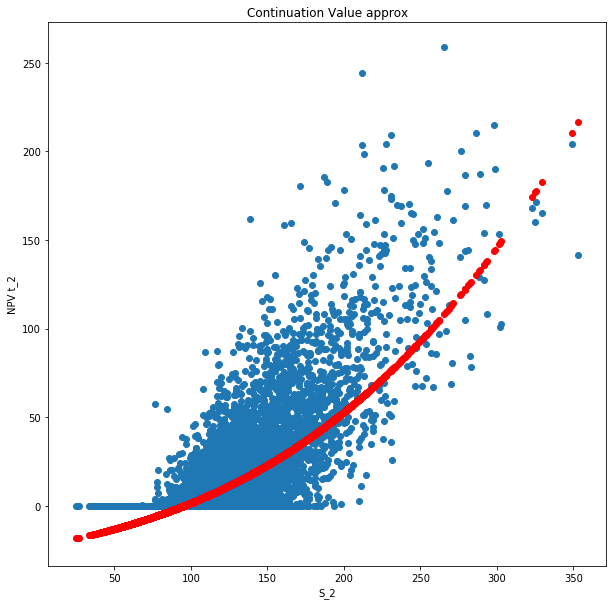

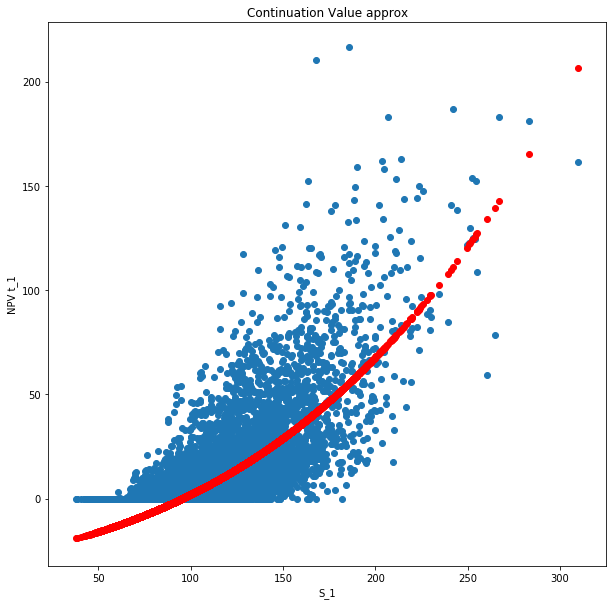

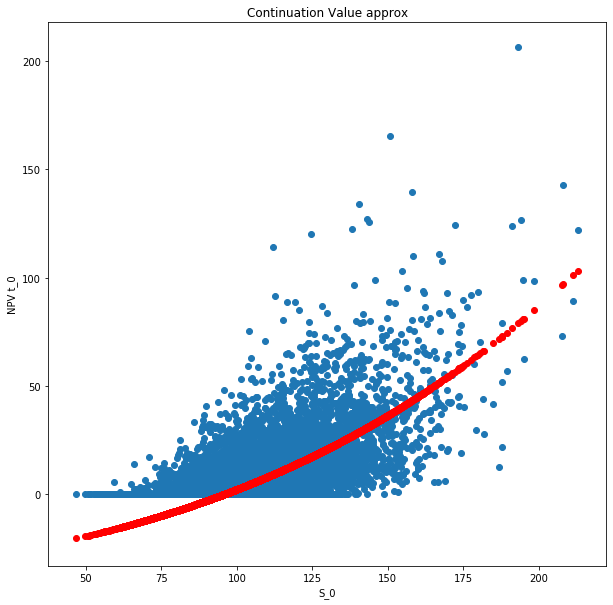

In [16]:
npv, greeks = bermudanMC_tensorFlow(100., 125., [1., 1., 1., 1.], 0.2, 0.03, N, N_pricing)

In [17]:
npv

11.119448

In [18]:
greeks

[0.485298, 129.19635, 79.30476]

### Runtime vs number of exercise dates

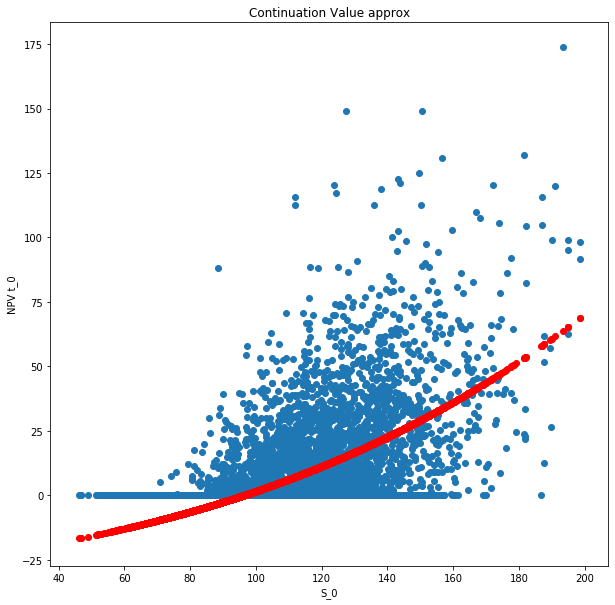

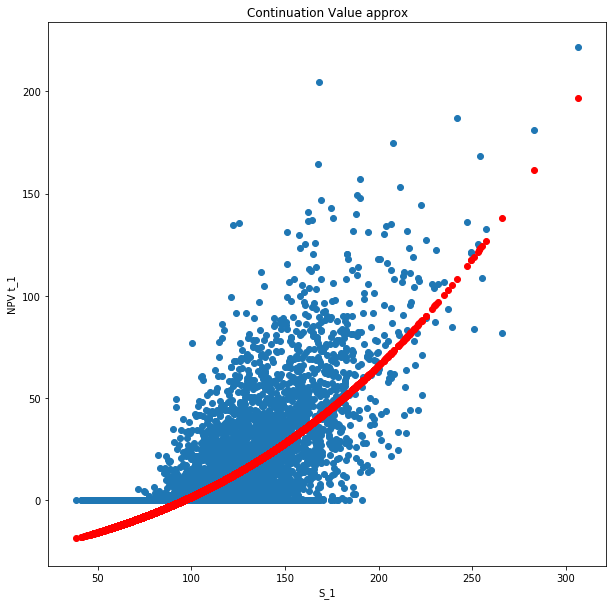

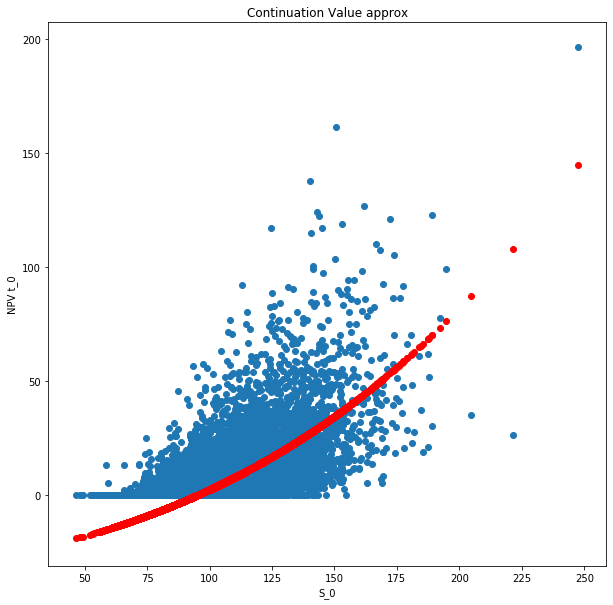

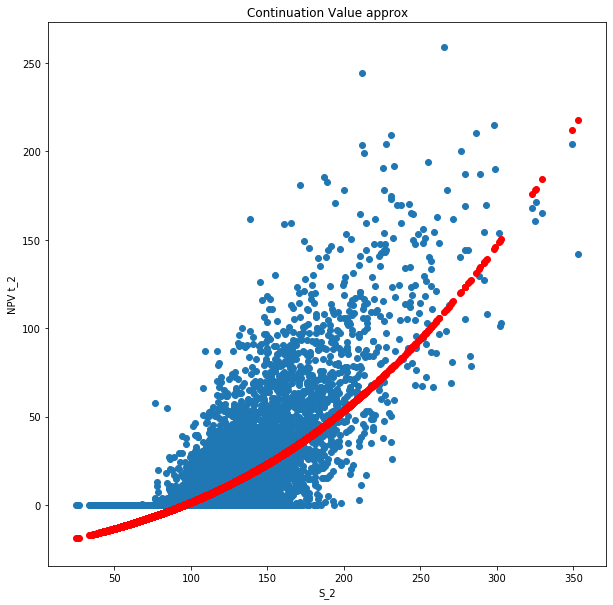

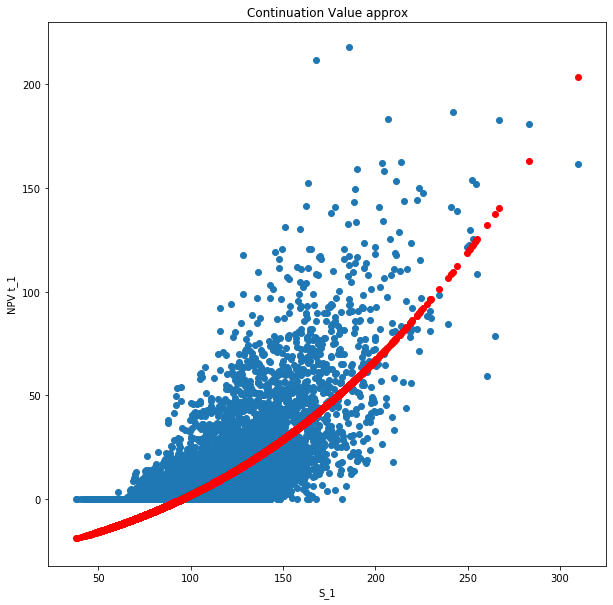

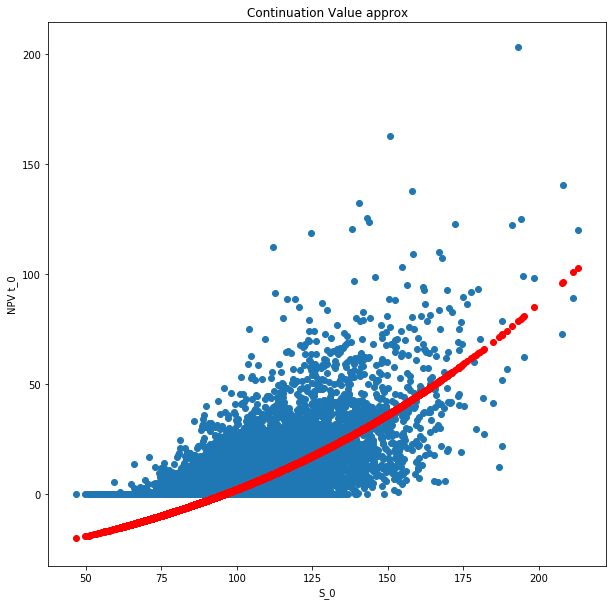

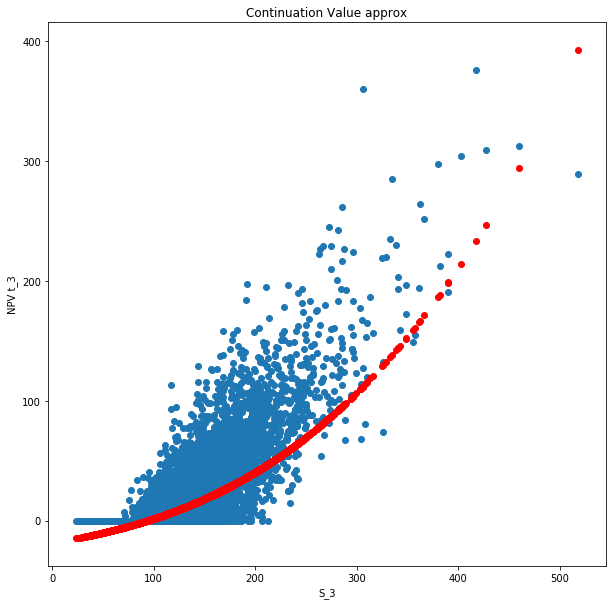

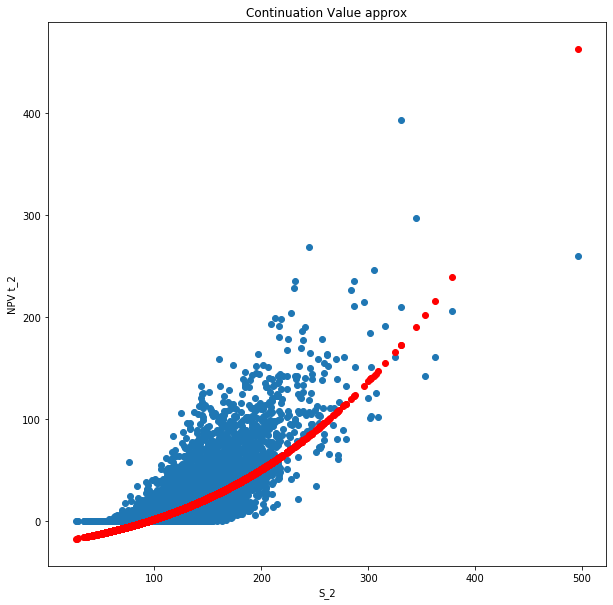

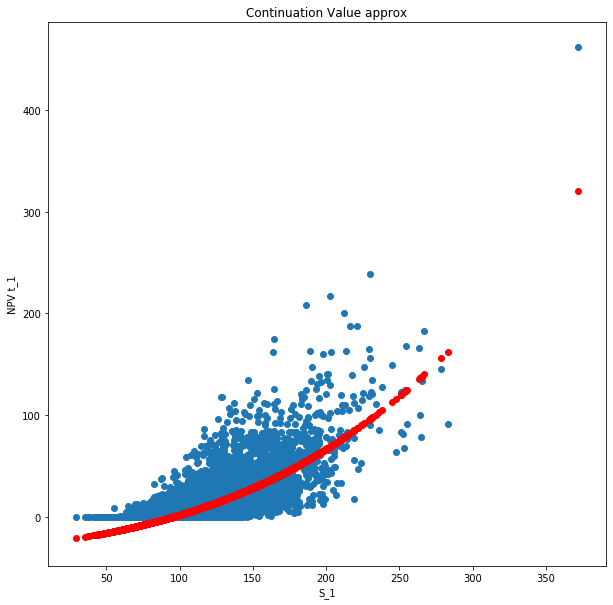

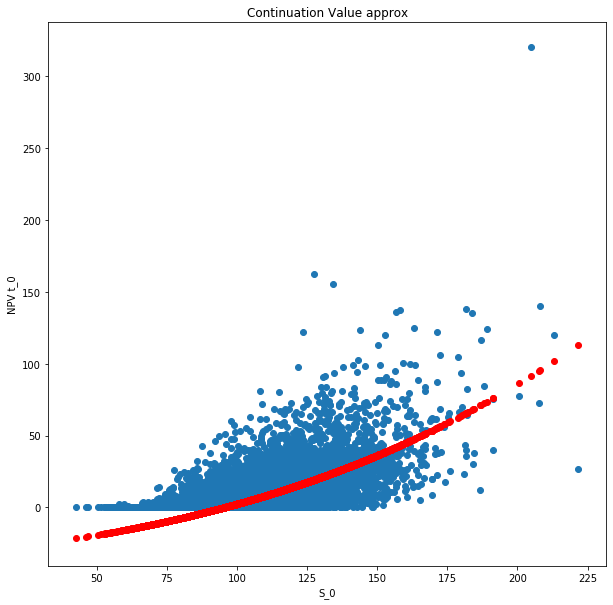

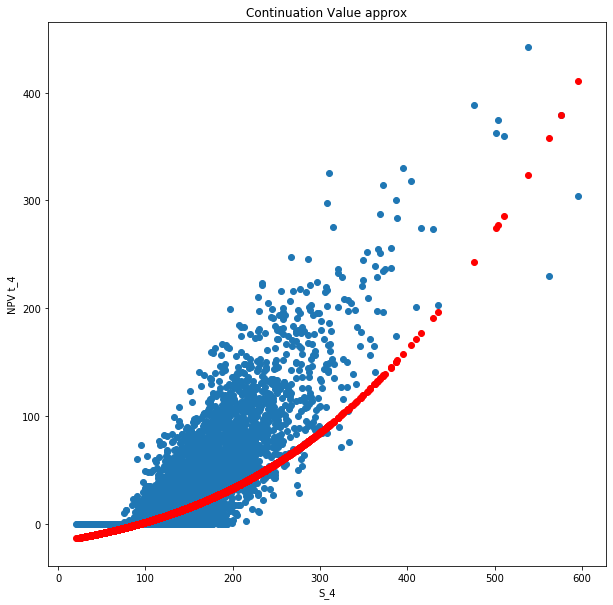

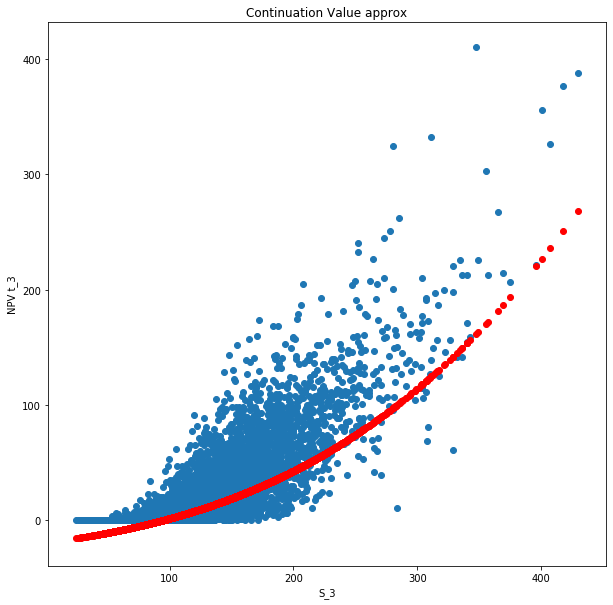

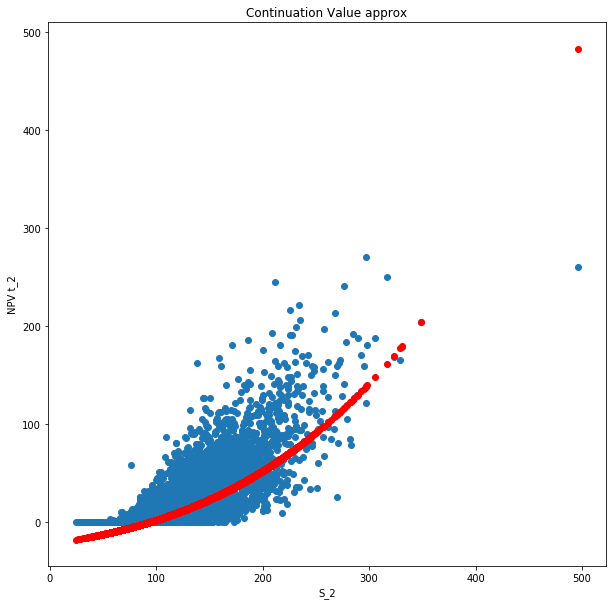

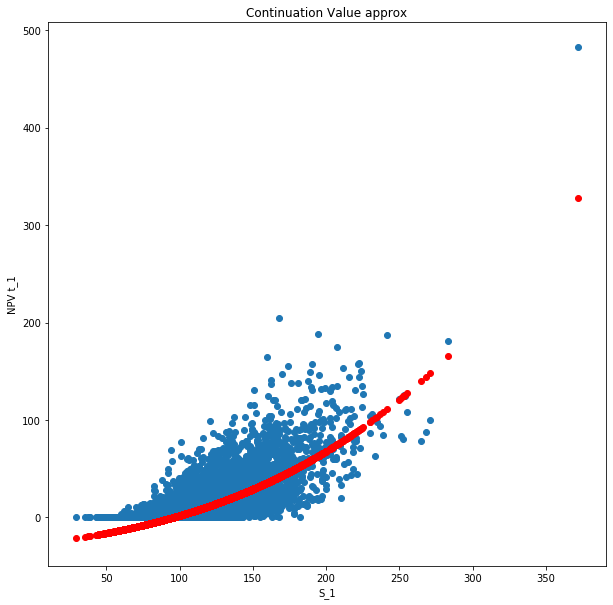

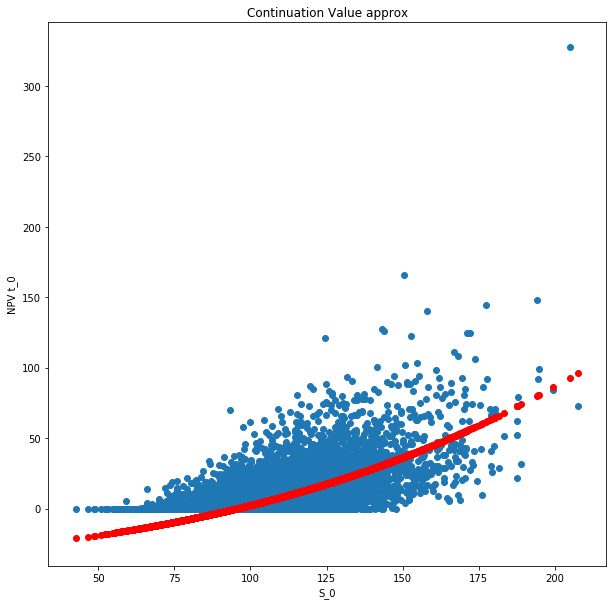

In [19]:
runtime = {}
for t in [[1.,1.], [1.,1.,1.], [1.,1.,1., 1.], [1.,1.,1., 1., 1,], [1.,1.,1., 1., 1, 1,]]:
    calldates = len(t)
    np.random.seed(42)
    # Training paths
    N = np.random.randn(N_samples_learn,calldates)
    # Pricing paths
    N_pricing = np.random.randn(N_samples_pricing,calldates)
    start = dt.datetime.now()
    bermudanMC_tensorFlow(100., 125., t, 0.2, 0.03, N, N_pricing)
    runtime[len(t)] = "%s" % (dt.datetime.now()-start)

In [21]:
pd.DataFrame(list(runtime.values()), list(runtime.keys()), columns=['RunTime'])

,RunTime
2,0:00:01.205781
3,0:00:01.633197
4,0:00:02.298091
5,0:00:03.112030
6,0:00:04.045782
